In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.cluster import KMeans


%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

We want fast anomaly detection, to find the bottom of the access regime "fan". This detection would be turned off inititally since we do not want to train on the early phases because they have a different, less defined set of features for describing a fan. We will attack this problem in the following order:

1. Anomaly detection, using the magnitudes of the minima (or their difference) to develop an objective function; the slope of this function will identify access regime chsanges
2. Dictionary learning using reduced/sparse-coding representations to find features and model the process with a neural representation
3. PCA AutoEncoder (linear method) to regenerate the model and predict access regimes

We are looking for different magnitudes of the same signal shape. From [Stats and Bots](https://blog.statsbot.co/time-series-anomaly-detection-algorithms-1cef5519aef2):

> In the case that you deal with some conversion funnel, there could be a drop in a conversion rate. If this happens, the target metric usually doesn’t change the shape of a signal, but rather its total value for a period. These types of changes are usually called level shifts or seasonal level shifts depending on the character of the change.

HOUGH TRANSFORM!!!!
FORMALIZE WHY ITS HARD TO FIND BARRIERS!!!

In [2]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../results/"
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... parsed : " + os.path.basename(results), 
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 100K", d+"scale-workers-4-71541/"))
stats.append(parse(dfs, "4 Node, 1M",   d+"scale-workers-1M-4-71537/"))
stats.append(parse(dfs, "1 Node, 100K", d+"scale-workers-1-71538"))
stats.append(parse(dfs, "1 Node, 1M",   d+"scale-workers-1M-1-71684"))    

... parsed :  ... parsed :  ... parsed : scale-workers-1-71538 ... parsed : scale-workers-1M-1-71684


## Workload
Key reads (*y* axis) over time (*x* axis) show "access regimes", or groups of accesses to the same set of keys:
- access regimes change immediately
- access regimes are different sizes
- access regimes get larger over time (**a**)
- random access to a single key (**b**), early keys accessed more (**c**)

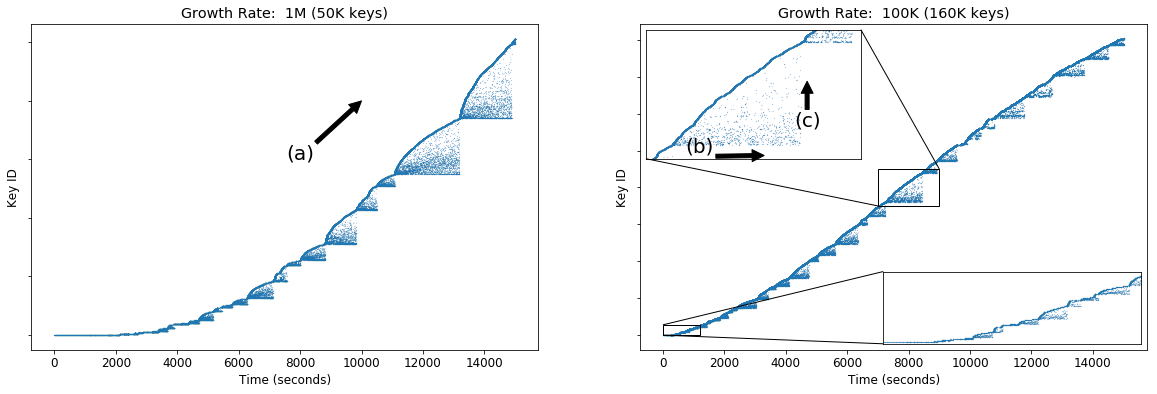

In [3]:
def plot_keytimes(ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    ts = int(d['ts'].head(1))                      # first timestep
    
    # Create short names for the states
    states = {}
    i = 1
        
    # Iterate over keys and assign state id
    d = d.drop_duplicates()                     # drop duplicates
    stateIDs = []
    for key in d['key']:
        if key not in states:
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs

    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    ax.scatter(d['shift'], d['id'], s=0.005)
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    ax.set_yticklabels([])
    ax.set_title("Growth Rate: " + key_tuple[0].split(',')[1] + " (" + str(len(states)/1000) + "K keys)")

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_keytimes(ax[1], dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
plot_keytimes(ax[0], dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

# top left
axins = zoomed_inset_axes(ax[1],3.5,loc=2)
plot_keytimes(axins, dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
axins.set_xlim(7000, 9000)
axins.set_ylim(70000, 90000)
mark_inset(ax[1], axins, loc1=3, loc2=1, color="black", ec="0")
axins.set_xlabel(""); axins.set_xticks([]); axins.set_ylabel(""); axins.set_yticks([]); axins.set_title("")

# annotate
ax[0].annotate("(a)", xy=(10000, 40000), xytext=(8000, 30000), arrowprops=dict(facecolor='black'), ha="center", fontsize=20)
axins.annotate("(b)", xy=(8100, 70500), xytext=(7500, 71000), arrowprops=dict(facecolor='black'), ha="center", fontsize=20)
axins.annotate("(c)", xy=(8500, 82000), xytext=(8500, 75000), arrowprops=dict(facecolor='black'), ha="center", fontsize=20)

# bottom right
axins = zoomed_inset_axes(ax[1],7,loc=4)
plot_keytimes(axins, dfs, ("4 Node, 100K", "DBMemoryGet", "4"))
axins.set_xlim(0, 1200)
axins.set_ylim(-100, 5500)
mark_inset(ax[1], axins, loc1=3, loc2=2, color="black", ec="0")
axins.set_xlabel(""); axins.set_xticks([]); axins.set_ylabel(""); axins.set_yticks([]); axins.set_title("")
plt.savefig("./key-accesses.png", bbox_inches='tight', dpi=400)

## K-Means Clustering
First find *K*, the number of clusters in the data using the sum of the distances to the centroid. Then apply K-Means and color clusters.

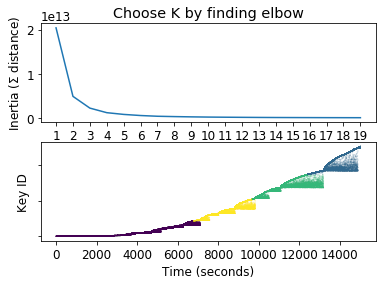

In [4]:
def plot_keytimes_kmeans(ax2, ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    d = d.drop_duplicates()                        # don't plot more than one point per (ts, id)
    ts = int(d['ts'].head(1))                      # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps

    stateIDs = []; states = {}; i = 1              # iterate over keys and assign state id
    for key in d['key']: 
        if key not in states:                      # if we haven't see key yet
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    
    # calculate kmeans
    f1 = d['ts'].astype(int)         # feature 1
    f2 = d['id'].astype(int)         # feature 2
    X=np.matrix(zip(f1, f2))
    kmeans = KMeans(n_clusters=4).fit(X)
    ax.scatter(d['shift'], d['id'], c=kmeans.labels_, s=0.005)       # plot
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    ax.set_yticklabels([])
    
    inertia = []
    for n in range(1, 20):
        kmeans = KMeans(n_clusters=n).fit(X)
        inertia.append(kmeans.inertia_)
    ax2.plot(range(1, len(inertia)+1), inertia)
    ax2.set_xticks(range(1, len(inertia)+1))
    ax2.set_title("Choose K by finding elbow")
    ax2.set_ylabel(r'Inertia ($\Sigma$ distance)')
    ax2.set_xlabel("number of clusters (K)")
    
fig, ax = plt.subplots(2, 1)
fig.subplots_adjust(wspace=0.5)
plot_keytimes_kmeans(ax[0], ax[1], dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

FAIL:
1. `K` is not known *a-priorio*
2. access regimes are different sizes

## DBScan

Set `eps` to 0.6 and the only feature is the key ID.

494
282


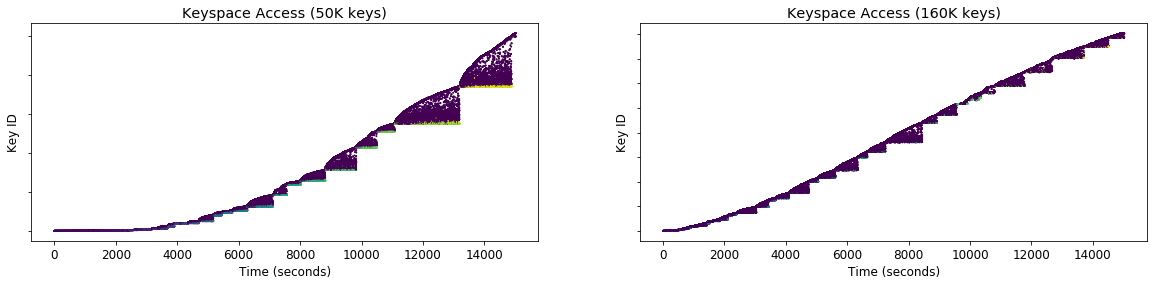

In [25]:
from sklearn.cluster import DBSCAN
def plot_keytimes_dbscan(ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    d = d.drop_duplicates()                        # don't plot more than one point per (ts, id)
    ts = int(d['ts'].head(1))                      # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    #d = d[d['shift'] < 4000]

    stateIDs = []; states = {}; i = 1              # iterate over keys and assign state id
    for key in d['key']: 
        if key not in states:                      # if we haven't see key yet
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    
    # calculate kmeans
    f1 = d['ts'].astype(int)         # feature 1
    f2 = d['id'].astype(int)         # feature 2
    X=np.matrix(zip(f2*f2))#, f2))
    dbscan = DBSCAN(eps=0.05).fit(X)
    #ax.scatter(d['shift'], d['id'], c=dbscan.labels_, s=0.005)       # plot
    colors = {}
    for label in dbscan.labels_:
        colors[label] = "blah"
    print len(colors)
    ax.scatter(d['shift'], d['id'], c=dbscan.labels_, s=1)       # plot

    #print dbscan.labels_
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    ax.set_yticklabels([])
    ax.set_title("Keyspace Access (" + str(len(states)/1000) + "K keys)")    
    
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
plot_keytimes_dbscan(ax[0], dfs, ("4 Node, 1M", "DBMemoryGet", "4"))
plot_keytimes_dbscan(ax[1], dfs, ("4 Node, 100K", "DBMemoryGet", "4"))

It kinda detects edges, but FAIL:
- Detected green edges are in the same group; detection happens too slowly
- What should we set `eps` to? (max distance between 2 samples in same neighborhood)
- What should we set `min_samples` to? (# of samples, i.e. total weight, for core point)

## Custom Algorithms

### Detect bottom "edge" of accesses
```
for each time stamp
  if key not in keys:
    timer -= 1
    if timer <= 0
      key = keys[0]
  else
    timer = COUNTDOWN_INIT
```

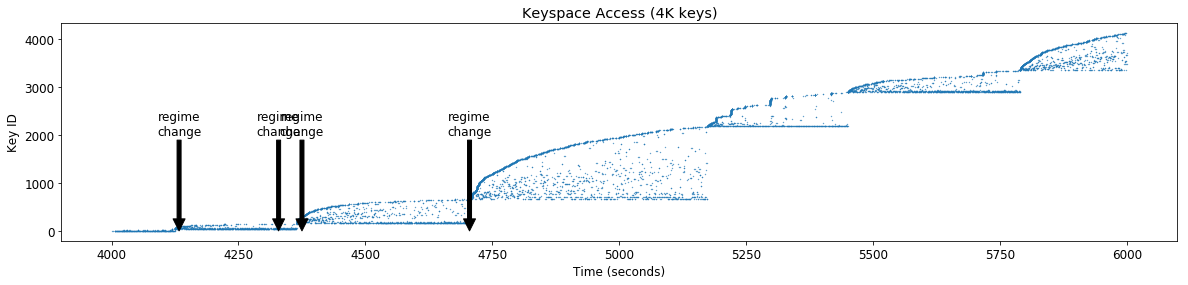

In [6]:
def plot_keytimes_custom(ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    d = d.drop_duplicates()                        # don't plot more than one point per (ts, id)
    ts = int(d['ts'].head(1))                      # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    d = d[d['shift'] > 4000]
    d = d[d['shift'] < 6000]

    stateIDs = []; states = {}; i = 1              # iterate over keys and assign state id
    for key in d['key']: 
        if key not in states:                      # if we haven't see key yet
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    
    tss = {}
    for _,e in d.iterrows():
        if e['shift'] not in tss:
            tss[e['shift']] = []
        tss[e['shift']].append(e['id'])
    
    cts = tss[4001.0]
    cid = tss[4001.0][0]
    INTERVAL=10
    cdown = INTERVAL
    for ts, ids in tss.iteritems():
        #print "cdown=" + str(cdown) + " ts=" +str(ts) + " cid=" + str(cid) + " ids=" + str(ids)
        
        if cid not in ids:
            
            cdown -= 1
            if cdown == 0:
                cid = ids[0]
                ax.annotate("regime\nchange", xy=(ts, 2), xytext=(ts, 2000),
                    arrowprops=dict(facecolor='black'), ha="center")
                #cdown = INTERVAL
        else:
            cdown = INTERVAL
            
    
    ax.scatter(d['shift'], d['id'], s=0.1)       # plot
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    #ax.set_yticklabels([])
    ax.set_title("Keyspace Access (" + str(len(states)/1000) + "K keys)")    
    
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_keytimes_custom(ax, dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

FAIL:
1. We don't know how long to wait before moving on
2. Edges contain both new and old events
3. We don't know what the bottom is of the next regime

### Maintain subsets of accesses
```
for each time stamp
  if key not in keys
    add key to keys
  if all keys are idle
    signal new regime
```

FAIL:
1. Keys from the next regime might get added to `keys`

# Goal: Learn ParSplice Locality
Molecules access states within superbasins over and over before jumping to a new superbasin. States are keys in the in-memory database. We want to apply on-line machine learning to detect when we are in one of these superbasins. We have a two pronged approach:

## 1. Fix PDSW Paper
We used machine learning to detect workload access regimes, based on throughput over time. Once detected, we sized the cache of the `n`-key policy to reduce memory pressure. We need plug the flaws in logic in using machine learning. There are two problems with this approach:
1. **unlimited policy**: is an unrealistic policy and skews the savings benefits
2. **machine learning not practical**: we need to choose either (1) online or (2) offline to build a model to use online

## 2. Next Paper
What machine learning techniques can we use to detect hotspots?

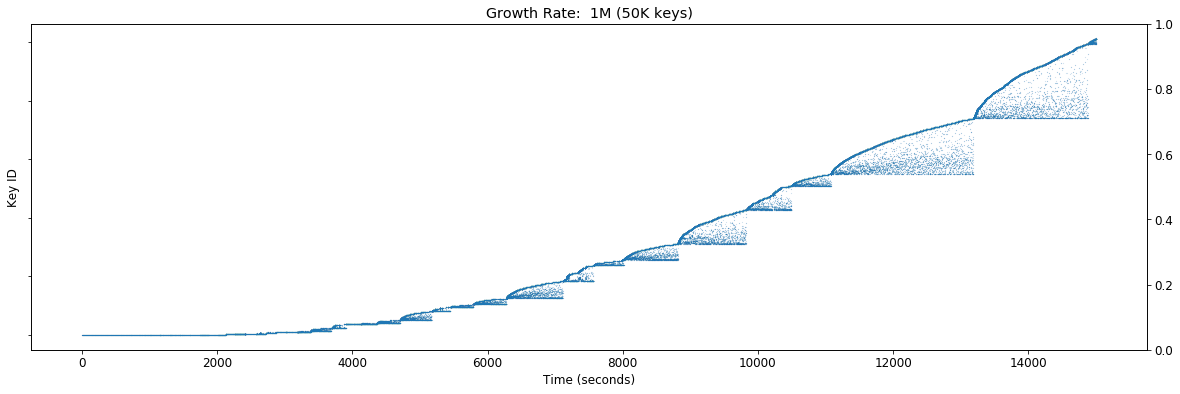

In [7]:
def plot_keytimes(ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    ts = int(d['ts'].head(1))                      # first timestep
    
    # Create short names for the states
    states = {}
    i = 1
        
    # Iterate over keys and assign state id
    d = d.drop_duplicates()                     # drop duplicates
    stateIDs = []
    for key in d['key']:
        if key not in states:
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs
    
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    ax.scatter(d['shift'], d['id'], s=0.005)
    
    # Get a time series pulse of unique keys
    dc = d.groupby('shift').size().reset_index()
    dc.columns=['shift', 'count']
    ax2 = ax.twinx()
    #ax2.plot(dc['shift'], dc['count'], lw=0.5, color='black')
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    ax.set_yticklabels([])
    ax.set_title("Growth Rate: " + key_tuple[0].split(',')[1] + " (" + str(len(states)/1000) + "K keys)")

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
plot_keytimes(ax, dfs, ("4 Node, 1M", "DBMemoryGet", "4"))